In [15]:
import matplotlib.pyplot as plt
import pandas as pd
from cdrift import evaluation
from cdrift.utils.helpers import readCSV_Lists, convertToTimedelta
import numpy as np
from datetime import datetime
from statistics import mean, harmonic_mean, stdev
from typing import List
import seaborn as sns
import re


LAG_WINDOW = 200
CSV_PATH = "evaluation_results_total.csv"

### Read the CSV and split by approach

In [16]:
df = readCSV_Lists(CSV_PATH)

### Rename Approaches to shorter names

In [17]:
print(df["Algorithm"].unique())
shorter_names = {
    "Zheng DBSCAN": "RINV",
    "ProDrift": "ProDrift",
    "Bose J": "J-Measure",
    "Bose WC": "Window Count",
    "Earth Mover's Distance": "EMD",
    "Process Graph Metrics": "PGM",
    "Martjushev ADWIN J": "ADWIN J",
    "Martjushev ADWIN WC": "ADWIN WC",
}
df["Algorithm"] = df["Algorithm"].map(shorter_names)
df["Algorithm"].unique()

['Zheng DBSCAN' 'ProDrift' 'Bose J' 'Bose WC' "Earth Mover's Distance"
 'Martjushev ADWIN J' 'Martjushev ADWIN WC' 'Process Graph Metrics']


array(['RINV', 'ProDrift', 'J-Measure', 'Window Count', 'EMD', 'ADWIN J',
       'ADWIN WC', 'PGM'], dtype=object)

In [18]:
# Order in which to plot the approaches, to stay consistent
ALPHA_SORT_NAMES = sorted(list(df["Algorithm"].unique()))
ALPHA_SORT_NAMES

['ADWIN J',
 'ADWIN WC',
 'EMD',
 'J-Measure',
 'PGM',
 'ProDrift',
 'RINV',
 'Window Count']

##### Only use Atomic Logs

In [19]:
atomic_logs = {
    log
    for index, (source, log) in df[["Log Source", "Log"]].iterrows()
    if (source.lower() == "ostovar" and log.lower().startswith("atomic")) # Only use atomic logs from ostovar
    or (log.lower().startswith("bose")) # Use bose log
    or (source.lower() == "ceravolo" and set(log.lower().split("_")[-1]) != {'i', 'o', 'r'}) # Exclude all composite (IOR, ROI, etc.) logs from ceravolo
}

df = df[df["Log"].isin(atomic_logs)]

In [20]:
def split_by_name(df):
    return [
        (alg, df[df["Algorithm"] == alg].copy())
        for alg in df["Algorithm"].unique()
    ]

dfs = split_by_name(df)

if not pd.read_csv(CSV_PATH).duplicated().any():
    print("No duplicate rows in the Dataframe! :)")
else:
    for name, d in split_by_name(pd.read_csv(CSV_PATH)):
        print(f"{name} contains duplicate rows: {d.duplicated().any()}")
df

No duplicate rows in the Dataframe! :)


,Algorithm,Log Source,Log,Min Adaptive Window,Max Adaptive Window,Detected Changepoints,Actual Changepoints for Log,F1-Score,Average Lag,Duration,P-Value,MRID,Epsilon,Window Size,SW Step Size,ADWIN Step Size
0,RINV,Ostovar,Atomic_Frequency_output_Frequency_5,NaN,NaN,[1516.9802143446002],"[999, 1999]",NaN,NaN,0 days 00:00:04,NaN,400.0,40.0,NaN,NaN,NaN
1,RINV,Ostovar,Atomic_Frequency_output_Frequency_5,NaN,NaN,[1516.9802143446002],"[999, 1999]",NaN,NaN,0 days 00:00:04,NaN,400.0,80.0,NaN,NaN,NaN
2,RINV,Ostovar,Atomic_Frequency_output_Frequency_5,NaN,NaN,[1516.9802143446002],"[999, 1999]",NaN,NaN,0 days 00:00:04,NaN,400.0,120.0,NaN,NaN,NaN
3,RINV,Ostovar,Atomic_Frequency_output_Frequency_5,NaN,NaN,[1516.9802143446002],"[999, 1999]",NaN,NaN,0 days 00:00:04,NaN,400.0,160.0,NaN,NaN,NaN
4,RINV,Ostovar,Atomic_Frequency_output_Frequency_5,NaN,NaN,[1516.9802143446002],"[999, 1999]",NaN,NaN,0 days 00:00:04,NaN,400.0,200.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32307,ADWIN J,Ostovar,Atomic_ConditionalMove_output_ConditionalMove,200.0,500.0,"[971, 1915]","[999, 1999]",1.000000,56.0,0 days 00:07:28,0.4000,NaN,NaN,NaN,NaN,10.0
32308,ADWIN WC,Ostovar,Atomic_ConditionalMove_output_ConditionalMove,200.0,500.0,[],"[999, 1999]",NaN,NaN,0 days 00:03:21,0.4000,NaN,NaN,NaN,NaN,10.0
32309,PGM,Ostovar,Atomic_ConditionalToSequence_output_Conditiona...,400.0,400.0,[1041],"[999, 1999]",0.666667,42.0,0 days 00:00:31,0.0001,NaN,NaN,NaN,NaN,NaN
32312,PGM,Ceravolo,sudden_trace_noise15_1000_cf,400.0,500.0,[765],[499],NaN,NaN,0 days 00:00:12,0.0500,NaN,NaN,NaN,NaN,NaN


#### Add Auxiliary Columns for Noise and Change Pattern

In [21]:
mapping_ostovar_to_shortnames = {
    "ConditionalMove": 'cm',
    "ConditionalRemoval": 'cre',
    "ConditionalToSequence": 'cf',
    "Frequency": 'fr',
    "Loop": 'lp',
    "ParallelMove": 'pm',
    "ParallelRemoval": 'pre',
    "ParallelToSequence": 'pl',
    "SerialMove": 'sm',
    "SerialRemoval": 'sre',
    "Skip": 'cb',
    "Substitute": 'rp',
    "Swap": 'sw',
}

def map_row_to_cp(row):
    logname = row["Log"]
    if row["Log Source"] == "Ceravolo":
        return logname.split("_")[-1]
    elif row["Log Source"] == "Ostovar":
        change_pattern = logname.split("_")[-1]
        if change_pattern.isnumeric(): # This log has a noise level; Use the second to last string instead
            change_pattern = logname.split("_")[-2]
        return mapping_ostovar_to_shortnames[change_pattern]
    elif row["Log Source"] == "Bose":
        return None
    else:
        raise ValueError(f"Unknown Log Source for Versatility: {row['Log Source']}; Is this Log meant to be used for a Versatility Evaluation?")

# Add a column stating the change pattern that is applied
df["Change Pattern"] = df.apply(lambda x: map_row_to_cp(x), axis=1)

In [22]:
# Preprocessing; Add "Noise Level" Column
def map_row_to_noise(row):
    logname = row["Log"]
    if row["Log Source"] == "Ceravolo":
        return re.search('noise([0-9]*)_', logname).group(1)
    elif row["Log Source"] == "Ostovar":
        # return mapping_ostovar_to_shortnames[logname.split("_")[-1]]
        last_member = logname.split('_')[-1]
        if last_member.isnumeric():
            return last_member
        else:
            return '0'
    elif row["Log Source"] == "Bose":
        return None
    else:
        raise ValueError(f"Unknown Log Source for Noise Level: {row['Log Source']}; Is this Log meant to be used for a Robustness Evaluation?")

# Only use the Ceravolo and Ostovar Logs as Bose has only 1 log, i.e., no noise levels
# Add a column stating the change pattern that is applied and one for the noise level
df["Noise Level"] = df.apply(lambda x: map_row_to_noise(x), axis=1)
df[['Algorithm', 'Log Source', 'Log', 'Change Pattern', 'Noise Level']]

,Algorithm,Log Source,Log,Change Pattern,Noise Level
0,RINV,Ostovar,Atomic_Frequency_output_Frequency_5,fr,5
1,RINV,Ostovar,Atomic_Frequency_output_Frequency_5,fr,5
2,RINV,Ostovar,Atomic_Frequency_output_Frequency_5,fr,5
3,RINV,Ostovar,Atomic_Frequency_output_Frequency_5,fr,5
4,RINV,Ostovar,Atomic_Frequency_output_Frequency_5,fr,5
...,...,...,...,...,...
32307,ADWIN J,Ostovar,Atomic_ConditionalMove_output_ConditionalMove,cm,0
32308,ADWIN WC,Ostovar,Atomic_ConditionalMove_output_ConditionalMove,cm,0
32309,PGM,Ostovar,Atomic_ConditionalToSequence_output_Conditiona...,cf,2
32312,PGM,Ceravolo,sudden_trace_noise15_1000_cf,cf,15


### Split into noisy/noiseful logs

In [23]:
logs = zip(df["Log Source"], df["Log"])

noiseless_logs = {
    log for source, log in logs if 
    (source == "Ostovar"  and not (log.endswith("_2") or log.endswith("_5"))) or
    (source == "Ceravolo" and log.split("_")[2]=="noise0") or
    source == "Bose"
}

df_noiseless = df[df["Log"].isin(noiseless_logs)]
df_noisy = df[df["Log"].isin(noiseless_logs) == False]

dfs_noisy = split_by_name(df_noisy)
dfs_noiseless = split_by_name(df_noiseless)

## Accuracy
- All Change-Patterns
- Only 0 Noise
- Max cummulative *Recall* achieved of all parameter settings
  - Accumulate TP and FP over all event logs before calculating recall

In [24]:
df["Algorithm"].unique()

array(['RINV', 'ProDrift', 'J-Measure', 'Window Count', 'EMD', 'PGM',
       'ADWIN J', 'ADWIN WC'], dtype=object)

In [25]:
used_parameters = {
        "Bose J": ["Window Size", "SW Step Size"],
        "Bose WC": ["Window Size", "SW Step Size"],
        "Martjushev ADWIN J": ["Min Adaptive Window", "Max Adaptive Window", "P-Value", "ADWIN Step Size"],
        "Martjushev ADWIN WC": ["Min Adaptive Window", "Max Adaptive Window", "P-Value", "ADWIN Step Size"],
        "ProDrift": ["Window Size", "SW Step Size"],
        "Earth Mover's Distance": ["Window Size", "SW Step Size"],
        "Process Graph Metrics": ["Min Adaptive Window", "Max Adaptive Window", "P-Value"],
        "Zheng DBSCAN": ["MRID", "Epsilon"]
    }

used_parameters = {
    shorter_names[name]: used_parameters[name]
    for name in used_parameters.keys()
}



def calcAccuracy(df:pd.DataFrame, param_names:List[str], lag_window: int):
    """Calculates the Accuracy Metric for the given dataframe by grouping by the given parameters and calculating the mean accuracy

    Args:
        df (pd.DataFrame): The dataframe containing the results to be evaluated
        param_names (List[str]): The names of the parameters of this approach
        lag_window (int): The lag window to be used for the evaluation to determine true positives and false positives

    Returns:
        _type_: _description_
    """

    f1s = dict()
    recalls = dict()
    precisions = dict()
    # Group by parameter values to calculate accuracy per parameter setting, over all logs
    for parameters, group in df.groupby(by=param_names):
        # Calculate Accuracy for this parameter setting
        ## --> F1-Score, but first collect all TP and FP
        tps = 0
        fps = 0
        positives = 0
        detected = 0

        # Collect TP FP, etc. 
        for index, row in group.iterrows():
            actual_cp = row["Actual Changepoints for Log"]
            detected_cp = row["Detected Changepoints"]
            tp, fp = evaluation.getTP_FP(detected_cp, actual_cp, lag_window)
            tps += tp
            fps += fp
            positives += len(actual_cp)
            detected += len(detected_cp)

        try:
            precisions[parameters] = tps / detected
        except ZeroDivisionError:
            precisions[parameters] = np.NaN
        
        try:
            recalls[parameters] = tps / positives
        except ZeroDivisionError:
            recalls[parameters] = np.NaN

        f1s[parameters] = harmonic_mean([precisions[parameters], recalls[parameters]]) # If either is nan, the harmonic mean is nan
    return (precisions, recalls, f1s)

def calculate_accuracy_metric_df(df_, lag_window, verbose=True):
    computed_accuracy_dicts = dict()
    computed_precision_dicts = dict()
    computed_recall_dicts = dict()

    accuracy_best_param = dict()

    accuracies = dict()
    for name, a_df in df_.groupby(by="Algorithm"):
        computed_precision_dicts[name], computed_recall_dicts[name], computed_accuracy_dicts[name] = calcAccuracy(a_df, used_parameters[name], LAG_WINDOW)

        best_param = max(computed_accuracy_dicts[name],  key=lambda x: computed_accuracy_dicts[name][x])

        accuracy_best_param[name] = best_param

        # accuracies[name] = max(computed_accuracy_dicts[name].values())
        accuracies[name] = computed_accuracy_dicts[name][best_param]
        if verbose:
            print(f"{name}: {accuracies[name]}")

    return (accuracies, computed_accuracy_dicts, computed_precision_dicts, computed_recall_dicts, accuracy_best_param)

accuracies, computed_accuracy_dicts, computed_precision_dicts, computed_recall_dicts, accuracy_best_param = calculate_accuracy_metric_df(df_noiseless, LAG_WINDOW)

ADWIN J: 0.75
ADWIN WC: 0
EMD: 0.8333333333333334
J-Measure: 0.7901234567901234
PGM: 0.7647058823529412
ProDrift: 0.5964912280701754
RINV: 0.8641975308641975
Window Count: 0.7428571428571429


#### Plot Accuracy as Barplot of Precision, Recall, F1

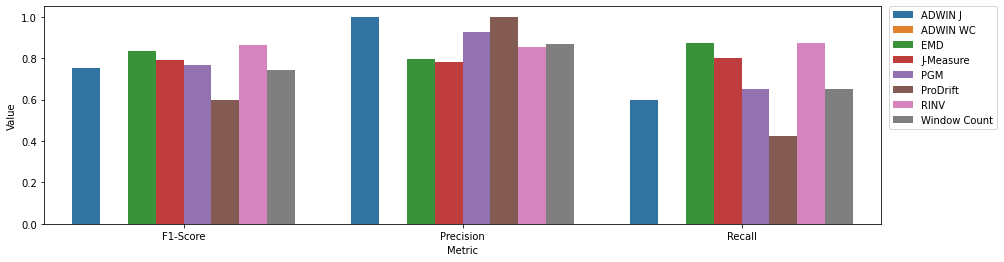

In [27]:
accuracy_plot_df = pd.DataFrame(
    [
        {
            "Algorithm": name,
            "Metric": "F1-Score",
            "Value": computed_accuracy_dicts[name][accuracy_best_param[name]]
        }
        for name in computed_accuracy_dicts.keys()
    ] + [
        {
            "Algorithm": name,
            "Metric": "Precision",
            "Value": computed_precision_dicts[name][accuracy_best_param[name]]
        }
        for name in computed_accuracy_dicts.keys()
    ] + [
        {
            "Algorithm": name,
            "Metric": "Recall",
            "Value": computed_recall_dicts[name][accuracy_best_param[name]]
        }
        for name in computed_accuracy_dicts.keys()
    ]
)

palette=None #{"Precision": "#573deb", "F1-Score": "#ff0076", "Recall": "#ffa600"}
ax = sns.barplot(x="Metric", y="Value", data=accuracy_plot_df, hue="Algorithm", palette=palette, hue_order=ALPHA_SORT_NAMES)

ax.figure.set_size_inches(15, 4)
# ax.tick_params(labelrotation=10, ha="right")
# Set each ticks horizontal alignment to "right"
# for tick in ax.get_xticklabels():
#     tick.set_ha("right")
#     tick.set_rotation(20)

plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)

plt.savefig("Final_Eval/accuracy.pdf", bbox_inches="tight", format="pdf")
plt.show()

### Plot as Points

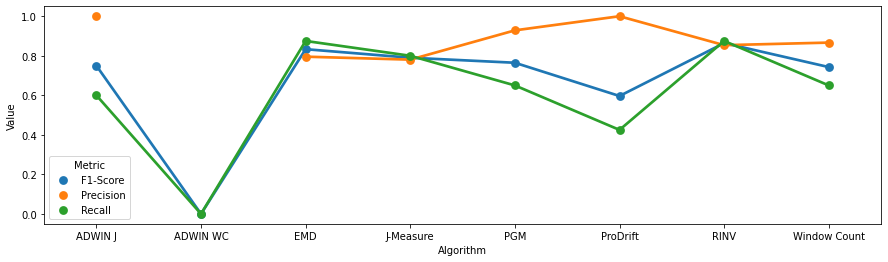

In [28]:
ax = sns.pointplot(
    x="Algorithm",
    y="Value",
    data=accuracy_plot_df,
    hue="Metric",
    order=ALPHA_SORT_NAMES,
    join=True,
)
ax.figure.set_size_inches(15, 4)
plt.show()

## Latency
- Using best parameter setting
- Same logs as above

In [29]:
from statistics import mean

def calcLatencies(df, param_names, lag_window):
    latencies = dict()
    for parameters, group in df.groupby(by=param_names):
        lags = []
        for index, row in group.iterrows():
            actual_cp = row["Actual Changepoints for Log"]
            detected_cp = row["Detected Changepoints"]
            assignments = evaluation.assign_changepoints(detected_cp, actual_cp, lag_window)
            for d, a in assignments:
                lags.append(abs(d-a))
        latencies[parameters] = lags
    return latencies

def calculate_latency(dataframe, lag_window, verbose=True):
    latencies = dict() # Dict holding the best achieved latency per approach
    scaled_latency_dicts = dict() # Dict holding the scaled mean latency per approach per parameter setting
    computed_latency_dicts = dict() # Dict holding the raw list of detection lags per approach per parameter setting
    best_params_latency = dict() # Dict holding the best parameter setting per approach (the one that achieves the best latency)
    for name, a_df in dataframe.groupby(by="Algorithm"):
        result = calcLatencies(a_df, used_parameters[name], LAG_WINDOW)
        computed_latency_dicts[name] = result
        latency_scaled_dict = {
            param: 1-(mean(result[param])/LAG_WINDOW) if len(result[param]) > 0 else np.NaN
            for param in result.keys()
        }
        scaled_latency_dicts[name] = latency_scaled_dict
        best_param = max(latency_scaled_dict,  key=lambda x: latency_scaled_dict[x])
        best_params_latency[name] = best_param
        latencies[name] = latency_scaled_dict[best_param]
        if verbose:
            print(f"{name}: {(1-latencies[name])*LAG_WINDOW} Traces; Score: {latencies[name]}")
    return (latencies, scaled_latency_dicts, computed_latency_dicts, best_params_latency)

latencies, scaled_latency_dicts, computed_latency_dicts, best_params_latency = calculate_latency(df_noiseless, LAG_WINDOW)

ADWIN J: 66.72 Traces; Score: 0.6664
ADWIN WC: nan Traces; Score: nan
EMD: 43.896551724137936 Traces; Score: 0.7805172413793103
J-Measure: 52.629629629629626 Traces; Score: 0.7368518518518519
PGM: 48.45000000000002 Traces; Score: 0.7577499999999999
ProDrift: 18.294117647058815 Traces; Score: 0.9085294117647059
RINV: 54.04231802148467 Traces; Score: 0.7297884098925767
Window Count: 41.57142857142857 Traces; Score: 0.7921428571428571


#### Plot Latency
- Plotting the observed average latency along with the corresponding standard deviation for the found best parameter setting

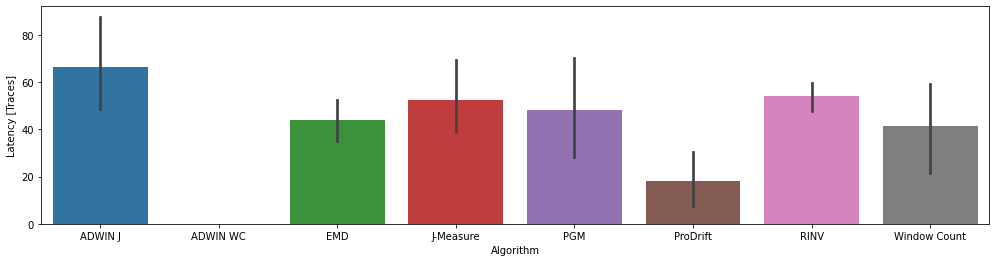

In [30]:
latency_plot_df = pd.DataFrame([
    {
        "Algorithm": name,
        "Unscaled Latency": latency
    }
    for name in computed_latency_dicts.keys()
    for latency in computed_latency_dicts[name][best_params_latency[name]]
])

ax = plt.subplots(figsize=(17, 4))

# Order by latency, ascending (best is left)
# order = [name for name, _ in sorted(latencies.items(), key=lambda x: x[1] if not np.isnan(x[1]) else 0, reverse=True)]
# print(order)
sns.barplot(x="Algorithm", y="Unscaled Latency", data=latency_plot_df, order=ALPHA_SORT_NAMES)
plt.ylabel("Latency [Traces]")
plt.savefig("Final_Eval/latency.pdf", bbox_inches="tight", format="pdf")


## Versatility

#### Preprocessing

In [31]:
# mapping_ostovar_to_shortnames = {
#     "ConditionalMove": 'cm',
#     "ConditionalRemoval": 'cre',
#     "ConditionalToSequence": 'cf',
#     "Frequency": 'fr',
#     "Loop": 'lp',
#     "ParallelMove": 'pm',
#     "ParallelRemoval": 'pre',
#     "ParallelToSequence": 'pl',
#     "SerialMove": 'sm',
#     "SerialRemoval": 'sre',
#     "Skip": 'cb',
#     "Substitute": 'rp',
#     "Swap": 'sw',
# }

# def map_row_to_cp(row):
#     logname = row["Log"]
#     if row["Log Source"] == "Ceravolo":
#         return logname.split("_")[-1]
#     elif row["Log Source"] == "Ostovar":
#         change_pattern = logname.split("_")[-1]
#         if change_pattern.isnumeric(): # This log has a noise level; Use the second to last string instead
#             change_pattern = logname.split("_")[-2]
#         return mapping_ostovar_to_shortnames[change_pattern]
#     else:
#         raise ValueError(f"Unknown Log Source for Versatility: {row['Log Source']}; Is this Log meant to be used for a Versatility Evaluation?")
# # Only use the Ceravolo and Ostovar Logs as Bose has only 1 log with various change points
df_v = df_noiseless[df_noiseless["Log Source"].isin(["Ceravolo", "Ostovar"])].copy(deep=True)
# # Add a column stating the change pattern that is applied
# df_v["Change Pattern"] = df_v.apply(lambda x: map_row_to_cp(x), axis=1)


#### Calculation
- Recall of all logs of the same pattern, "concatenated", i.e., accumulate TP and FP first
- Divide this by the number of change patterns

In [32]:
# TODO: Map an approach to a dict mapping param setting to change patterns to recall
# versatility_recall_dicts = dict() # Map approach to a dictionary mapping a change pattern to the recall achieved by the approach on this change pattern
# versatilities = dict() # Map approach to versatility score
# for name, group in df_v.groupby(by=["Algorithm"]):
#     recalls_of_this_approach = dict()
#     for change_pattern, cp_group in group.groupby(by=["Change Pattern"]):
#         TPS = 0
#         POSITIVES = 0
#         # TP / TP+FN = TP / POSTIVES = Recall
#         for index, row in cp_group.iterrows():
#             detected_changepoints = row["Detected Changepoints"]
#             actual_changepoints = row["Actual Changepoints for Log"]

#             tp, _ = evaluation.getTP_FP(detected_changepoints, actual_changepoints, LAG_WINDOW)

#             TPS += tp
#             POSITIVES += len(actual_changepoints)

#         # Recall of this algorithm for this change pattern:
#         recall = TPS / POSITIVES if POSITIVES != 0 else np.NaN # Only the case if there are no actual changepoints, which should not be the case
#         recalls_of_this_approach[change_pattern] = recall
#     versatility_recall_dicts[name] = recalls_of_this_approach
#     versatilities[name] = mean(recalls_of_this_approach.values())
#     print(f"{name}: {versatilities[name]}")


In [35]:
def calc_versatility(dataframe, lag_window, verbose=True):

    versatility_recall_dicts = dict() # Map approach to a dictionary mapping param setting to mean recall over all change patterns
    versatilities = dict() # Map approach to versatility score
    best_params_versatility = dict() # Map approach to best param setting

    for name, group in dataframe.groupby(by=["Algorithm"]):
        recalls_of_this_approach = dict()
        for params, params_group in group.groupby(by=used_parameters[name]):
            recalls = dict()
            for change_pattern, cp_group in params_group.groupby(by=["Change Pattern"]):
                TPS = 0
                POSITIVES = 0
                # TP / TP+FN = TP / POSTIVES = Recall
                for index, row in cp_group.iterrows():
                    detected_changepoints = row["Detected Changepoints"]
                    actual_changepoints = row["Actual Changepoints for Log"]

                    tp, _ = evaluation.getTP_FP(detected_changepoints, actual_changepoints, lag_window)

                    TPS += tp
                    POSITIVES += len(actual_changepoints)

                # Recall of this algorithm for this change pattern:
                recall = TPS / POSITIVES if POSITIVES != 0 else np.NaN # Only the case if there are no actual changepoints, which should not be the case
                recalls[change_pattern] = recall
            recalls_of_this_approach[params] = recalls
        versatility_recall_dicts[name] = recalls_of_this_approach
        best_param = max(recalls_of_this_approach, key=lambda x: np.nanmean(list(recalls_of_this_approach[x].values()))) # .values() gives us all the recalls for all change patterns on this param setting
        best_params_versatility[name] = best_param
        versatilities[name] = np.nanmean(list(
            recalls_of_this_approach[best_param].values()
        ))
        
        if verbose:
            print(f"{name}: {versatilities[name]}")
        
    return versatilities, versatility_recall_dicts, best_params_versatility

versatilities, versatility_recall_dicts, best_params_versatility = calc_versatility(df_v, LAG_WINDOW)


ADWIN J: 0.59375
ADWIN WC: 0.0
EMD: 0.875
J-Measure: 0.7708333333333333
PGM: 0.65625
ProDrift: 0.38541666666666663
RINV: 0.8541666666666666
Window Count: 0.625


#### Plot
- Barplot with "bar" for each change pattern and approach

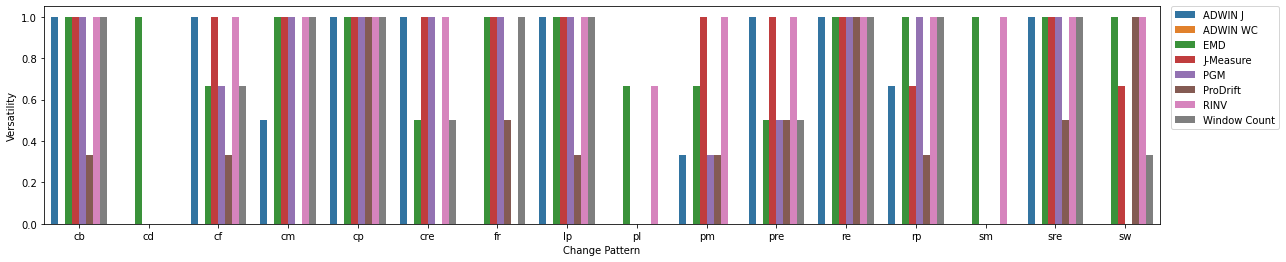

In [36]:
df_vers_plot = pd.DataFrame([
    {
        "Algorithm": name,
        "Change Pattern": cp,
        "Versatility": versatility_recall_dicts[name][best_params_versatility[name]][cp]
    }
    for name in versatility_recall_dicts.keys()
    for cp in versatility_recall_dicts[name][best_params_versatility[name]].keys()
])


fig,ax = plt.subplots(figsize=(20, 4))
sns.barplot(x="Change Pattern", y="Versatility", data=df_vers_plot, hue="Algorithm", ax=ax, hue_order=ALPHA_SORT_NAMES)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.savefig("Final_Eval/versatility.pdf", bbox_inches="tight", format="pdf")
plt.show()

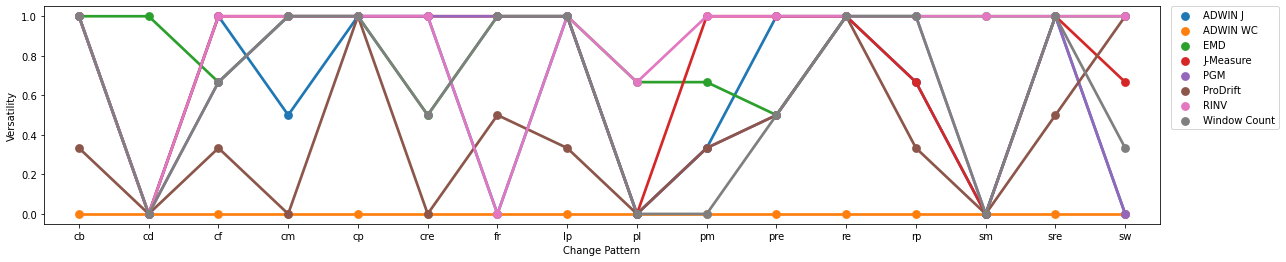

In [37]:
change_patterns = sorted(list(df_vers_plot["Change Pattern"].unique()))
ax = sns.pointplot(
    x="Change Pattern",
    y="Versatility",
    data=df_vers_plot,
    hue="Algorithm",
    hue_order=ALPHA_SORT_NAMES,
    order=change_patterns
)
ax.figure.set_size_inches(20,4)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.show()

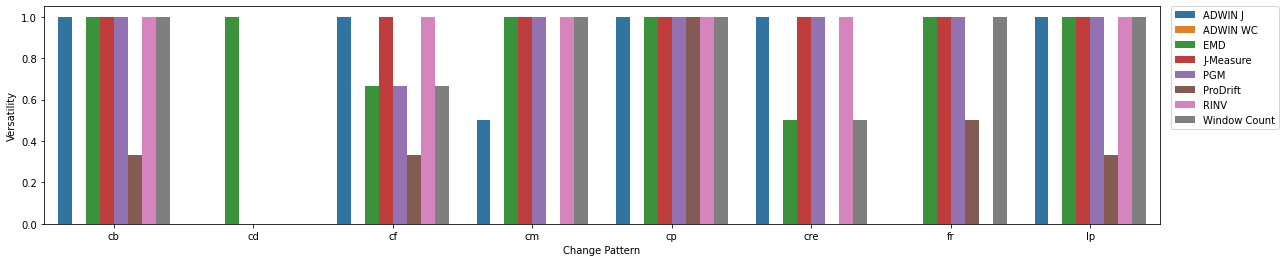

In [38]:
# Plot again, but split in half
first_half = change_patterns[:len(change_patterns)//2]
second_half = change_patterns[len(change_patterns)//2:]
fig,ax = plt.subplots(figsize=(20, 4))
sns.barplot(x="Change Pattern", y="Versatility", data=df_vers_plot[df_vers_plot["Change Pattern"].isin(first_half)], hue="Algorithm", order=first_half, ax=ax, hue_order=ALPHA_SORT_NAMES)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.savefig("Final_Eval/versatility_split_1.pdf", bbox_inches="tight", format="pdf")
plt.show()

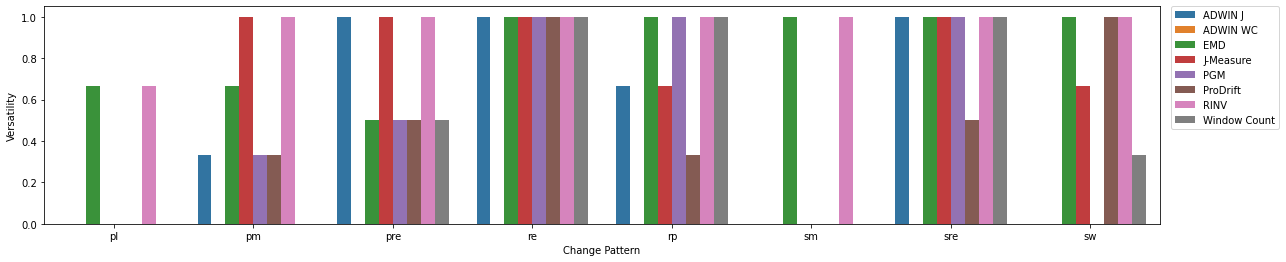

In [39]:
fig2,ax2 = plt.subplots(figsize=(20, 4))
sns.barplot(x="Change Pattern", y="Versatility", data=df_vers_plot[df_vers_plot["Change Pattern"].isin(second_half)], hue="Algorithm", order=second_half, ax=ax2, hue_order=ALPHA_SORT_NAMES)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.savefig("Final_Eval/versatility_split_2.pdf", bbox_inches="tight", format="pdf")

#### Plot as Radar Plot (Trying out plotly first)

In [40]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# fig.write_image("Final_Eval/versatility_polar.pdf")

# fig = px.line_polar(df_vers_plot[df_vers_plot["Algorithm"] == "EMD"], r='Versatility', theta='Change Pattern', line_close=True)

fig = make_subplots(rows=2, cols=2, start_cell="bottom-left")
for idx, (alg, dataframe) in enumerate(df_vers_plot.groupby(by="Algorithm")):
    aux_fig = px.line_polar(df_vers_plot[df_vers_plot["Algorithm"] == alg], r='Versatility', theta='Change Pattern', line_close=True)
    aux_fig.update_traces(fill='toself'),
    fig.add_trace(
        aux_fig,
        row=idx//2+1, col=idx%2+1
    )

# Multiple approaches at once
# fig = go.Figure()
# for alg, dataframe in df_vers_plot.groupby(by="Algorithm"):
#     fig.add_trace(go.Scatterpolar(
#       r = dataframe["Versatility"],
#       theta = dataframe["Change Pattern"],
#       fill = 'toself',
#       name = alg
# ))



# fig.update_layout(
#   polar=dict(
#     radialaxis=dict(
#       visible=True,
#       range=[0, 5]
#     )),
#   showlegend=False
# )

fig.show()

ValueError: 
    Invalid element(s) received for the 'data' property of 
        Invalid elements include: [Figure({
    'data': [{'fill': 'toself',
              'hovertemplate': 'Versatility=%{r}<br>Change Pattern=%{theta}<extra></extra>',
              'legendgroup': '',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': '',
              'r': array([1.        , 0.        , 1.        , 0.5       , 1.        , 1.        ,
                          0.        , 1.        , 0.        , 0.33333333, 1.        , 1.        ,
                          0.66666667, 0.        , 1.        , 0.        , 1.        ]),
              'showlegend': False,
              'subplot': 'polar',
              'theta': array(['cb', 'cd', 'cf', 'cm', 'cp', 'cre', 'fr', 'lp', 'pl', 'pm', 'pre',
                              're', 'rp', 'sm', 'sre', 'sw', 'cb'], dtype=object),
              'type': 'scatterpolar'}],
    'layout': {'legend': {'tracegroupgap': 0},
               'margin': {'t': 60},
               'polar': {'angularaxis': {'direction': 'clockwise', 'rotation': 90},
                         'domain': {'x': [0.0, 1.0], 'y': [0.0, 1.0]}},
               'template': '...'}
})]

    The 'data' property is a tuple of trace instances
    that may be specified as:
      - A list or tuple of trace instances
        (e.g. [Scatter(...), Bar(...)])
      - A single trace instance
        (e.g. Scatter(...), Bar(...), etc.)
      - A list or tuple of dicts of string/value properties where:
        - The 'type' property specifies the trace type
            One of: ['bar', 'barpolar', 'box', 'candlestick',
                     'carpet', 'choropleth', 'choroplethmapbox',
                     'cone', 'contour', 'contourcarpet',
                     'densitymapbox', 'funnel', 'funnelarea',
                     'heatmap', 'heatmapgl', 'histogram',
                     'histogram2d', 'histogram2dcontour', 'icicle',
                     'image', 'indicator', 'isosurface', 'mesh3d',
                     'ohlc', 'parcats', 'parcoords', 'pie',
                     'pointcloud', 'sankey', 'scatter',
                     'scatter3d', 'scattercarpet', 'scattergeo',
                     'scattergl', 'scattermapbox', 'scatterpolar',
                     'scatterpolargl', 'scattersmith',
                     'scatterternary', 'splom', 'streamtube',
                     'sunburst', 'surface', 'table', 'treemap',
                     'violin', 'volume', 'waterfall']

        - All remaining properties are passed to the constructor of
          the specified trace type

        (e.g. [{'type': 'scatter', ...}, {'type': 'bar, ...}])

## Scalability
- Mean Duration
- Across ***all*** logs this time!

In [41]:
scalabilities = dict()
for name, a_df in dfs:
    result = a_df["Duration"].mean()
    result_str = datetime.strftime(datetime.utcfromtimestamp(result.seconds), '%H:%M:%S')
    scalabilities[name] = {"datetime": result, "str": result_str}
    print(f"{name}: {result_str}")

RINV: 00:00:02
ProDrift: 00:03:31
J-Measure: 00:09:14
Window Count: 00:09:13
EMD: 00:13:05
PGM: 00:00:24
ADWIN J: 00:03:41
ADWIN WC: 00:02:13


#### Plot Boxplot

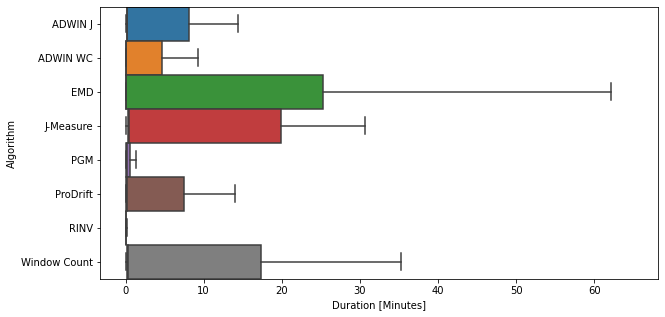

In [42]:
scalability_plot_df = pd.DataFrame([
    {
        "Algorithm": name,
        "Duration": duration.total_seconds() / 60
    }
    for name, a_df in dfs
    for duration in a_df["Duration"].tolist()
])

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlabel("Duration [Minutes]")

sorted_names = list(scalabilities.items())
sorted_names.sort(key=lambda x: x[1]["datetime"])

sns.boxplot(
    data=scalability_plot_df,
    order=ALPHA_SORT_NAMES,#[name for name, _ in sorted_names] if False else None, # Disable sorting for now, maybe this means that the order is the same in every plot
    x="Duration",
    y="Algorithm",
    width=1,
    ax=ax,
    fliersize=0
)
plt.xlabel("Duration [Minutes]")
plt.savefig("Final_Eval/scalability.pdf", bbox_inches="tight", format="pdf")

#### Plot as Barplot as well

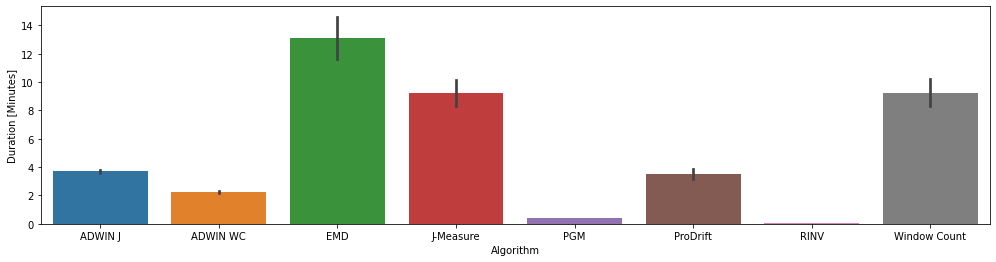

In [43]:
scalability_barplot_df = pd.DataFrame([
    {
        "Algorithm": name,
        "Duration": duration.total_seconds() / 60
    }
    for name, a_df in dfs
    for duration in a_df["Duration"].tolist()
])

ax = plt.subplots(figsize=(17, 4))

# Order by latency, ascending (best is left)
# order = [name for name, _ in sorted(latencies.items(), key=lambda x: x[1] if not np.isnan(x[1]) else 0, reverse=True)]
# print(order)
sns.barplot(x="Algorithm", y="Duration", data=scalability_barplot_df, order=ALPHA_SORT_NAMES)
plt.ylabel("Duration [Minutes]")
plt.savefig("Final_Eval/scalability_barplot.pdf", bbox_inches="tight", format="pdf")

## Parameter Sensitivity
- For each Parameter setting, harmonic mean of *accuracy*, *latency*, and *versatility*
  - &rarr; Visualize the variance, etc., with a boxplot
- Only noiseless logs again

In [44]:
versatility_score_per_param = {
    name: {
        params: np.nanmean(list(versatility_recall_dicts[name][params].values()))
        for params in versatility_recall_dicts[name].keys()
    }
    for name in versatility_recall_dicts.keys()
}


sensitivities = dict()
for name in df["Algorithm"].unique():
    _sensitivities = dict()
    acc = computed_accuracy_dicts[name]
    lat = scaled_latency_dicts[name]
    vers = versatility_score_per_param[name]
    for param_choice in acc.keys():
        sensitivity = harmonic_mean([acc[param_choice], vers[param_choice], lat[param_choice]])
        _sensitivities[param_choice] = sensitivity
    sensitivities[name] = _sensitivities


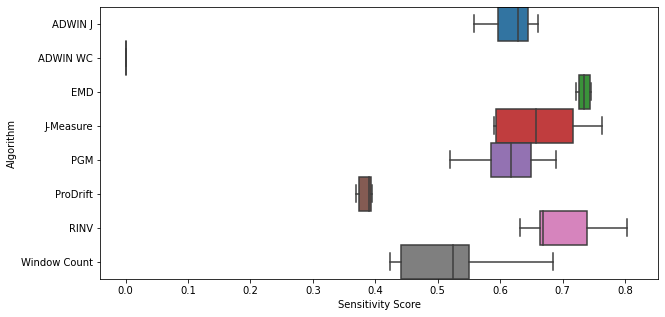

In [45]:
sens_df = pd.DataFrame([
    {
        "Parameters": param,
        "Algorithm": name,
        "Sensitivity Score": sens
    }
    for name, sens_dict in sensitivities.items()
    for param, sens in sens_dict.items()
])
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(
    data=sens_df,
    x="Sensitivity Score",
    y="Algorithm",
    width=1,
    ax=ax,
    fliersize=0,
    order=ALPHA_SORT_NAMES
)
plt.savefig("Final_Eval/param_sensitivity.pdf", bbox_inches="tight", format="pdf")

In [46]:
# Standard Deviation
print("Standard Deviations")

def try_calc_stdev(data):
    try:
        return stdev(data)
    except:
        return np.NaN

sensitivity_stds = dict()
for name, sens in sensitivities.items():
    std = try_calc_stdev(sens.values())
    sensitivity_stds[name] = std
    print(f"{name}: {std}")

Standard Deviations
RINV: 0.054226659935544444
ProDrift: 0.08439258367711411
J-Measure: 0.07764126508160589
Window Count: 0.1832978744988118
EMD: 0.03387752903080029
PGM: 0.04618787683409851
ADWIN J: 0.028353001745894054
ADWIN WC: 0.0


### Robustness

### Preprocessing; Add relevant columns to Dataframe

In [47]:
# # Preprocessing; Add "Noise Level" Column
# def map_row_to_noise(row):
#     logname = row["Log"]
#     if row["Log Source"] == "Ceravolo":
#         return re.search('noise([0-9]*)_', logname).group(1)
#     elif row["Log Source"] == "Ostovar":
#         # return mapping_ostovar_to_shortnames[logname.split("_")[-1]]
#         last_member = logname.split('_')[-1]
#         if last_member.isnumeric():
#             return last_member
#         else:
#             return '0'
#     elif row["Log Source"] == "Bose":
#         return None
#     else:
#         raise ValueError(f"Unknown Log Source for Noise Level: {row['Log Source']}; Is this Log meant to be used for a Robustness Evaluation?")

# # Only use the Ceravolo and Ostovar Logs as Bose has only 1 log, i.e., no noise levels
df_robust = df[df["Log Source"].isin(["Ceravolo", "Ostovar"])].copy(deep=True)
# # Add a column stating the change pattern that is applied and one for the noise level
# df_lat["Change Pattern"] = df_lat.apply(lambda x: map_row_to_cp(x), axis=1)
# df_lat["Noise Level"] = df_lat.apply(lambda x: map_row_to_noise(x), axis=1)
df_robust[['Algorithm', 'Log Source', 'Log', 'Change Pattern', 'Noise Level']]

,Algorithm,Log Source,Log,Change Pattern,Noise Level
0,RINV,Ostovar,Atomic_Frequency_output_Frequency_5,fr,5
1,RINV,Ostovar,Atomic_Frequency_output_Frequency_5,fr,5
2,RINV,Ostovar,Atomic_Frequency_output_Frequency_5,fr,5
3,RINV,Ostovar,Atomic_Frequency_output_Frequency_5,fr,5
4,RINV,Ostovar,Atomic_Frequency_output_Frequency_5,fr,5
...,...,...,...,...,...
32307,ADWIN J,Ostovar,Atomic_ConditionalMove_output_ConditionalMove,cm,0
32308,ADWIN WC,Ostovar,Atomic_ConditionalMove_output_ConditionalMove,cm,0
32309,PGM,Ostovar,Atomic_ConditionalToSequence_output_Conditiona...,cf,2
32312,PGM,Ceravolo,sudden_trace_noise15_1000_cf,cf,15


In [ ]:
robustnesses = dict()

for approach, approach_df in df_robust.groupby("Algorithm"):
    these_robustnesses = dict()
    for param_choice, param_group in approach_df.groupby(used_parameters["Process Graph Metrics"]):
        points = []
        for noise_level, noise_group in param_group.groupby(by="Noise Level"):
            acc =  None #calculate_accuracy(noise_group)
            lat =  None #calculate_latency(noise_group)
            vers = None # calculate_versatility(noise_group)

            points.append(harmonic_mean([acc, lat, vers]))
        these_robustnesses[param_choice] = stdev(points)
    robustnesses[approach] = these_robustnesses

for approach, robustness in robustnesses.items():
    print(f"{approach}: {min(robustness.values())}")


In [56]:
robustnesses_ostovar = dict()
# Only use Ceravolo logs while i figure out what i am doing
df_robust = df_robust[df_robust["Log Source"] == "Ceravolo"].copy(deep=True)

for noise_level, noise_df in df_robust.groupby("Noise Level"):
    # Calculate accuracy over these logs
    accuracies, _, _, _, _ = calculate_accuracy_metric_df(noise_df, LAG_WINDOW, verbose=False)
    latencies, _, _, _ = calculate_latency(noise_df, LAG_WINDOW, verbose=False)
    versatilities, _, _ = calc_versatility(noise_df, LAG_WINDOW, verbose=False)

    assert accuracies.keys() == latencies.keys() == versatilities.keys()

    robustnesses_ostovar[noise_level] = {
        approach: harmonic_mean([accuracies[approach], latencies[approach], versatilities[approach]])
        for approach in accuracies.keys()
    }

In [57]:
robustnesses_ostovar

{'0': {'ADWIN J': 0.6190476190476191,
  'ADWIN WC': 0,
  'EMD': 0.7514305719873482,
  'J-Measure': 0.7561702635030404,
  'PGM': 0.7785108388312912,
  'ProDrift': 0.8875673666604721,
  'RINV': 0.8089483615115577,
  'Window Count': 0.7028231797919763},
 '10': {'ADWIN J': 0.5641025641025641,
  'ADWIN WC': 0,
  'EMD': 0.7611202635914333,
  'J-Measure': 0.8109196688297158,
  'PGM': 0.7609316470719134,
  'ProDrift': 0.8875673666604721,
  'RINV': 0.8089483615115577,
  'Window Count': 0.6763754045307443},
 '15': {'ADWIN J': 0.6521739130434783,
  'ADWIN WC': 0,
  'EMD': 0.6996996996996997,
  'J-Measure': 0.77780691174157,
  'PGM': 0.8352951138961808,
  'ProDrift': 0.8872355266217159,
  'RINV': 0.8090695475524018,
  'Window Count': 0.7742155267042659},
 '20': {'ADWIN J': 0.6521739130434783,
  'ADWIN WC': 0,
  'EMD': 0.8109196688297158,
  'J-Measure': 0.8328720459868001,
  'PGM': 0.7902515245556544,
  'ProDrift': 0.8875673666604721,
  'RINV': 0.8089483615115577,
  'Window Count': 0.79694981379677

(0.0, 1.0)

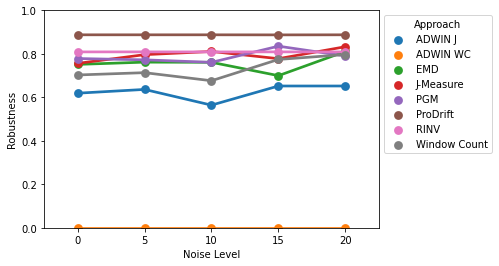

In [73]:
plot_df_robust = pd.DataFrame([
    {
        "Approach": name,
        "Noise Level": int(noise_level),
        "Robustness": robustness
    }
    for noise_level, robust_dict  in robustnesses_ostovar.items()
    for name, robustness in robust_dict.items()
])

ax = sns.pointplot(x="Noise Level", y="Robustness", hue="Approach", data=plot_df_robust, ci=None)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_ylim(0,1)

## Save Results

In [48]:
pd.DataFrame([
    {
        "Algorithm": name,
        "Accuracy": accuracies[name],
        "Latency": latencies[name],
        "Versatility:": versatilities[name],
        "Scalability": scalabilities[name]["str"],
        "Parameter Sensitivity (STD)": sensitivity_stds[name],
        "Robustness": None#robustnesses[name]
    }
    for name in df["Algorithm"].unique()
]).to_csv("evaluation_measures.csv", index=False)